# No Distro imgs

In [114]:
# correzione degli indici


import os
import csv
import random
import numpy as np
import cv2



path_HToBB = '/home/fede/Desktop/jet_patch_excl/Data_excl/HToBB_1_jet'
path_TTBar = '/home/fede/Desktop/jet_patch_excl/Data_excl/TTBar_1_jet'
path_ZJetsToNuNu = '/home/fede/Desktop/jet_patch_excl/Data_excl/QCD_1_jet'



def get_image_path_full(path):
    # Esclude i file che iniziano con "." o contengono ".sys."
    images = [os.path.join(path, f) for f in os.listdir(path) 
              if f.endswith('.jpg') and not f.startswith('.') and '.sys.' not in f]
    return images[0:2000]


def get_image_path_set_1(path):
    # Esclude i file che iniziano con "." o contengono ".sys."
    images = [os.path.join(path, f) for f in os.listdir(path) 
              if f.endswith('.jpg') and not f.startswith('.') and '.sys.' not in f]
    return images[0:4000]


def rotate_image(image, SIZE):
    tx, ty = 0, 0
    angle = random.randint(0, 360)
    center = (SIZE // 2, SIZE // 2)
    M_rotation = cv2.getRotationMatrix2D(center, angle, 1)
    M_rotation[0, 2] += tx
    M_rotation[1, 2] += ty
    transformed_image = cv2.warpAffine(image, M_rotation, (SIZE, SIZE), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed_image

def place_in_true_areas(base_image, overlay_image):
    h_base, w_base = base_image.shape
    h_overlay, w_overlay = overlay_image.shape
    true_mask = (base_image == 0)
    if h_overlay > h_base or w_overlay > w_base:
        raise ValueError("L'immagine overlay è più grande della matrice base!")
    for _ in range(1000): 
        x_start = random.randint(0, h_base - h_overlay)
        y_start = random.randint(0, w_base - w_overlay)
        selected_area = true_mask[x_start:x_start + h_overlay, y_start:y_start + w_overlay]
        if np.all(selected_area):
            base_image[x_start:x_start + h_overlay, y_start:y_start + w_overlay] = overlay_image
            return base_image
    raise ValueError("Non è stato possibile trovare una posizione valida per l'immagine!")

def get_bounding_box(image):
    non_zero_indices = np.argwhere(image > 0)
    ymin, xmin = non_zero_indices.min(axis=0)
    ymax, xmax = non_zero_indices.max(axis=0)
    width = xmax - xmin
    height = ymax - ymin
    return xmin, ymin, width, height



# Caricamento delle immagini
imgs_HToBB = get_image_path_full(path_HToBB)
imgs_TTBar_1 = get_image_path_set_1(path_TTBar)
imgs_QCD_1 = get_image_path_set_1(path_ZJetsToNuNu)

SIZE = 150

#THRESHOLD = 50 # for jet 100, 50, 25

#
# THRESHOLD = 20 # for jet 12
THRESHOLD = 10 # for jet 6

list_HToBB_1 = []
list_HToBB_1_bbox_1 = []
for path in imgs_HToBB:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (SIZE, SIZE))
    image = rotate_image(image, SIZE)
    image[image < THRESHOLD] = 0
    list_HToBB_1.append(image)
    xmin, ymin, width, height = get_bounding_box(image)
    list_HToBB_1_bbox_1.append([xmin, ymin, width, height])

list_QCD_1 = []
list_QCD_1_bbox_1 = []
for path in imgs_QCD_1:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (SIZE, SIZE))
    image = rotate_image(image, SIZE)
    image[image < THRESHOLD] = 0
    list_QCD_1.append(image)
    xmin, ymin, width, height = get_bounding_box(image)
    list_QCD_1_bbox_1.append([xmin, ymin, width, height])

list_TTBar_1 = []
list_TTBar_1_bbox_1 = []
for path in imgs_TTBar_1:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (SIZE, SIZE))
    image = rotate_image(image, SIZE)
    image[image < THRESHOLD] = 0
    list_TTBar_1.append(image)
    xmin, ymin, width, height = get_bounding_box(image)
    list_TTBar_1_bbox_1.append([xmin, ymin, width, height])


# Percorsi

output_image_dir = "/home/fede/Desktop/jet_patch_excl/jet_1_classe_1"

os.makedirs(output_image_dir, exist_ok=True)

output_csv_path = os.path.join(output_image_dir, "bounding_boxes_1_classe_1.csv")

# Parametri
MATRIX_SIZE = 800
IMAGE_SIZE = 150

# Lista di immagini da usare (assumendo che siano già caricate)
imgs_HToBB = list_HToBB_1.copy()
imgs_QCD = list_QCD_1.copy()
imgs_TTBar = list_TTBar_1.copy()

# Bounding box
bboxes_HToBB = list_HToBB_1_bbox_1.copy()
bboxes_QCD = list_QCD_1_bbox_1.copy()
bboxes_TTBar = list_TTBar_1_bbox_1.copy()

# Apertura file CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_name", "hbb_xmin", "hbb_ymin", "hbb_width", "hbb_height",
                     "qcd1_xmin", "qcd1_ymin", "qcd1_width", "qcd1_height",
                     "qcd2_xmin", "qcd2_ymin", "qcd2_width", "qcd2_height"])

    
    # Loop su tutte le immagini HToBB
    for i in range(min(len(imgs_HToBB), len(imgs_QCD), len(imgs_TTBar))):
        # Creazione della matrice vuota
        zero_matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uint8)
        true_mask = np.ones((MATRIX_SIZE, MATRIX_SIZE), dtype=bool)
        
        # Selezione immagini
        hbb_image = imgs_HToBB.pop(0)
        qcd_image_1 = imgs_QCD.pop(0)
        qcd_image_2 = imgs_QCD.pop(0)
        ttbar_image_1 = imgs_TTBar.pop(0)
        ttbar_image_2 = imgs_TTBar.pop(0)
        
        # Selezione bounding boxes
        xmin_hbb, ymin_hbb, width_hbb, height_hbb = bboxes_HToBB.pop(0)
        xmin_qcd1, ymin_qcd1, width_qcd1, height_qcd1 = bboxes_QCD.pop(0)
        xmin_qcd2, ymin_qcd2, width_qcd2, height_qcd2 = bboxes_QCD.pop(0)
        xmin_ttbar1, ymin_ttbar1, width_ttbar1, height_ttbar1 = bboxes_TTBar.pop(0)
        xmin_ttbar2, ymin_ttbar2, width_ttbar2, height_ttbar2 = bboxes_TTBar.pop(0)

        def place_image(image, bbox):
            while True:
                for _ in range(1000):
                    x_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
                    y_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
                    selected_area = true_mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE]
                    if np.all(selected_area):
                        zero_matrix[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = image
                        true_mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = False
                        return x_start + bbox[0], y_start + bbox[1], bbox[2], bbox[3]
                print("Riprovando a trovare una posizione valida...")
        
        # Posizionamento immagini
        new_xmin_hbb, new_ymin_hbb, width_hbb, height_hbb = place_image(hbb_image, (xmin_hbb, ymin_hbb, width_hbb, height_hbb))
        new_xmin_qcd1, new_ymin_qcd1, width_qcd1, height_qcd1 = place_image(qcd_image_1, (xmin_qcd1, ymin_qcd1, width_qcd1, height_qcd1))
        new_xmin_qcd2, new_ymin_qcd2, width_qcd2, height_qcd2 = place_image(qcd_image_2, (xmin_qcd2, ymin_qcd2, width_qcd2, height_qcd2))
        new_xmin_ttbar1, new_ymin_ttbar1, width_ttbar1, height_ttbar1 = place_image(ttbar_image_1, (xmin_ttbar1, ymin_ttbar1, width_ttbar1, height_ttbar1))
        new_xmin_ttbar2, new_ymin_ttbar2, width_ttbar2, height_ttbar2 = place_image(ttbar_image_2, (xmin_ttbar2, ymin_ttbar2, width_ttbar2, height_ttbar2))

        # Salvataggio immagine
        #image_name = f"image_1_50_jet_{i:04d}.jpg"
        #image_name = f"image_1_25_jet_{i:04d}.jpg"
        #image_name = f"image_1_12_jet_{i:04d}.jpg"
        image_name = f"image_1_1_jet_{i:04d}.jpg"


        cv2.imwrite(os.path.join(output_image_dir, image_name), zero_matrix)
        
        # Scrittura nel CSV
        writer.writerow([image_name, new_xmin_hbb, new_ymin_hbb, width_hbb, height_hbb,
                         new_xmin_qcd1, new_ymin_qcd1, width_qcd1, height_qcd1,
                         new_xmin_qcd2, new_ymin_qcd2, width_qcd2, height_qcd2])

print("Generazione completata! Immagini salvate e CSV aggiornato.")


Generazione completata! Immagini salvate e CSV aggiornato.


In [115]:
import os
import cv2
import csv
import numpy as np
import random

def get_image_path_set(path, start, end):
    images = [os.path.join(path, f) for f in os.listdir(path) 
              if f.endswith('.jpg') and not f.startswith('.') and '.sys.' not in f]
    return images[start:end]

# Percorsi delle immagini


path_TTBar = '/home/fede/Desktop/jet_patch_excl/Data_excl/TTBar_1_jet'
path_ZJetsToNuNu = '/home/fede/Desktop/jet_patch_excl/Data_excl/QCD_1_jet'

# Caricamento delle immagini
imgs_QCD = get_image_path_set(path_ZJetsToNuNu, 4001, 10000)
imgs_TTBar = get_image_path_set(path_TTBar, 4001, 10000)

SIZE = 150
#THRESHOLD = 50 # for jet 100, 50, 25

# THRESHOLD = 20 # for jet 12
THRESHOLD = 10 # for jet 6
# Funzione per la rotazione

def rotate_image(image, SIZE):
    angle = random.randint(0, 360)
    center = (SIZE // 2, SIZE // 2)
    M_rotation = cv2.getRotationMatrix2D(center, angle, 1)
    transformed_image = cv2.warpAffine(image, M_rotation, (SIZE, SIZE), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed_image

# Funzione per bounding box
def get_bounding_box(image):
    non_zero_indices = np.argwhere(image > 0)
    ymin, xmin = non_zero_indices.min(axis=0)
    ymax, xmax = non_zero_indices.max(axis=0)
    return xmin, ymin, xmax - xmin, ymax - ymin

# Elaborazione immagini
list_QCD = []
list_QCD_bbox = []
for path in imgs_QCD:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (SIZE, SIZE))
    image = rotate_image(image, SIZE)
    image[image < THRESHOLD] = 0
    list_QCD.append(image)
    list_QCD_bbox.append(get_bounding_box(image))

list_TTBar = []
list_TTBar_bbox = []
for path in imgs_TTBar:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (SIZE, SIZE))
    image = rotate_image(image, SIZE)
    image[image < THRESHOLD] = 0
    list_TTBar.append(image)
    list_TTBar_bbox.append(get_bounding_box(image))

# Percorsi
#output_image_dir = "/home/fede/Desktop/jet_patch_excl/jet_50_classe_0"
#output_image_dir = "/home/fede/Desktop/jet_patch_excl/jet_25_classe_0"
#output_image_dir = "/home/fede/Desktop/jet_patch_excl/jet_12_classe_0"
output_image_dir = "/home/fede/Desktop/jet_patch_excl/jet_1_classe_0"

os.makedirs(output_image_dir, exist_ok=True)
#output_csv_path = os.path.join(output_image_dir, "bounding_boxes_50_classe_0.csv")
#output_csv_path = os.path.join(output_image_dir, "bounding_boxes_25_classe_0.csv")
#output_csv_path = os.path.join(output_image_dir, "bounding_boxes_12_classe_0.csv")
output_csv_path = os.path.join(output_image_dir, "bounding_boxes_1_classe_0.csv")

# Parametri
MATRIX_SIZE = 800
IMAGE_SIZE = 150

# Apertura file CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_name", "qcd1_xmin", "qcd1_ymin", "qcd1_width", "qcd1_height",
                     "qcd2_xmin", "qcd2_ymin", "qcd2_width", "qcd2_height",
                     "qcd3_xmin", "qcd3_ymin", "qcd3_width", "qcd3_height"])
    
    for i in range(min(len(list_QCD), len(list_TTBar))):
        zero_matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uint8)
        true_mask = np.ones((MATRIX_SIZE, MATRIX_SIZE), dtype=bool)
        
        def place_image(image, bbox):
            for _ in range(1000):
                x_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
                y_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
                if np.all(true_mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE]):
                    zero_matrix[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = image
                    true_mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = False
                    return x_start + bbox[0], y_start + bbox[1], bbox[2], bbox[3]
            raise ValueError("Non è stato possibile trovare una posizione valida!")

        qcd1 = list_QCD.pop(0)
        qcd2 = list_QCD.pop(0)
        qcd3 = list_QCD.pop(0)
        ttbar1 = list_TTBar.pop(0)
        ttbar2 = list_TTBar.pop(0)
        
        bbox_qcd1 = list_QCD_bbox.pop(0)
        bbox_qcd2 = list_QCD_bbox.pop(0)
        bbox_qcd3 = list_QCD_bbox.pop(0)
        bbox_ttbar1 = list_TTBar_bbox.pop(0)
        bbox_ttbar2 = list_TTBar_bbox.pop(0)
        
        new_qcd1 = place_image(qcd1, bbox_qcd1)
        new_qcd2 = place_image(qcd2, bbox_qcd2)
        new_qcd3 = place_image(qcd3, bbox_qcd3)
        new_ttbar1 = place_image(ttbar1, bbox_ttbar1)
        new_ttbar2 = place_image(ttbar2, bbox_ttbar2)

        #image_name = f"image_0_50_jet_{i:04d}.jpg"
        #image_name = f"image_0_25_jet_{i:04d}.jpg"
        #image_name = f"image_0_12_jet_{i:04d}.jpg"
        image_name = f"image_0_1_jet_{i:04d}.jpg"

        cv2.imwrite(os.path.join(output_image_dir, image_name), zero_matrix)
        
        writer.writerow([image_name, *new_qcd1, *new_qcd2, *new_qcd3])

print("Generazione completata! Immagini salvate e CSV aggiornato.")


IndexError: pop from empty list

# POISSON DISTRO

In [76]:
# update 8 maggio
# poisson con anche ttbar come fondo




import os
import csv
import random
import numpy as np
import cv2
from numpy.random import poisson
import matplotlib.pyplot as plt

# Percorsi delle immagini
path_HToBB = '/home/fede/Desktop/jet_patch_excl/Data_excl/HToBB_1_jet'
path_ZJetsToNuNu = '/home/fede/Desktop/jet_patch_excl/Data_excl/QCD_1_jet'
path_TTBar = '/home/fede/Desktop/jet_patch_excl/Data_excl/TTBar_1_jet'

# Funzioni
def get_image_path_full(path):
    images = [os.path.join(path, f) for f in os.listdir(path)
              if f.endswith('.jpg') and not f.startswith('.') and '.sys.' not in f]
    return images[0:9900]

def rotate_image(image, SIZE):
    angle = random.randint(0, 360)
    center = (SIZE // 2, SIZE // 2)
    M_rotation = cv2.getRotationMatrix2D(center, angle, 1)
    transformed_image = cv2.warpAffine(image, M_rotation, (SIZE, SIZE), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed_image

def get_bounding_box(image):
    non_zero_indices = np.argwhere(image > 0)
    if non_zero_indices.size == 0:
        return 0, 0, 0, 0
    ymin, xmin = non_zero_indices.min(axis=0)
    ymax, xmax = non_zero_indices.max(axis=0)
    width = xmax - xmin
    height = ymax - ymin
    return xmin, ymin, width, height

def place_image(image, bbox, matrix, mask):
    IMAGE_SIZE = 130
    MATRIX_SIZE = 512
    for _ in range(1000):
        x_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
        y_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
        selected_area = mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE]
        if np.all(selected_area):
            matrix[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = image
            mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = False
            return x_start + bbox[0], y_start + bbox[1], bbox[2], bbox[3]
    return None

# Caricamento immagini
def load_and_process_images(paths, threshold=10, size=130):   # threshold = 10 per 3 jet/blob
    images = []
    bboxes = []
    for path in paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (size, size))
        image = rotate_image(image, size)
        image[image < threshold] = 0
        images.append(image)
        bbox = get_bounding_box(image)
        bboxes.append(bbox)
    return images, bboxes

imgs_HToBB = get_image_path_full(path_HToBB)
imgs_QCD = get_image_path_full(path_ZJetsToNuNu)
imgs_TTBar = get_image_path_full(path_TTBar)  # Placeholder: da cambiare con path_TTBar

list_HToBB, bboxes_HToBB = load_and_process_images(imgs_HToBB)
list_QCD, bboxes_QCD = load_and_process_images(imgs_QCD)
list_TTBar, bboxes_TTBar = load_and_process_images(imgs_TTBar)

# Parametri
MATRIX_SIZE = 512
IMAGE_SIZE = 130
#output_image_dir = "/home/fede/Desktop/jet_patch_excl/Test_poisson_distro/" # questo era con 25 jet/blob
output_image_dir = "/home/fede/Desktop/jet_patch_excl/Poisson_distro_1/"

os.makedirs(output_image_dir, exist_ok=True)
output_csv_path = os.path.join(output_image_dir, "bounding_boxes_poisson_1.csv")

# Scrittura CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ["image_name"]
    for obj in ["hbb", "qcd", "ttbar"]:
        for i in range(1, 6):
            header += [f"{obj}{i}_xmin", f"{obj}{i}_ymin", f"{obj}{i}_width", f"{obj}{i}_height"]
    header.append("label")
    writer.writerow(header)

    max_images = 3000
    hbb_counts = []
    qcd_counts = []
    ttbar_counts = []
    label_counts = []

    for idx in range(max_images):
        if not (list_HToBB or list_QCD or list_TTBar):
            break

        canvas = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uint8)
        mask = np.ones((MATRIX_SIZE, MATRIX_SIZE), dtype=bool)
        entry = [f"image_poisson_{idx:04d}.jpg"]

        num_hbb = poisson(1)
        num_qcd = poisson(3)
        num_ttbar = poisson(3)

        total_requested = num_hbb + num_qcd + num_ttbar
        if total_requested > 5:
            scale = 5 / total_requested
            num_hbb = int(num_hbb * scale)
            num_qcd = int(num_qcd * scale)
            num_ttbar = int(num_ttbar * scale)


        if num_hbb > 0:
            label = 1
        elif num_qcd > 0:
            label = 0
        else:
            label = 2

        hbb_counts.append(num_hbb)
        qcd_counts.append(num_qcd)
        ttbar_counts.append(num_ttbar)
        label_counts.append(label)


        def place_and_record(images, bboxes, count):
            results = []
            for _ in range(5):
                if count > 0 and images:
                    img = images.pop(0)
                    bbox = bboxes.pop(0)
                    placed = place_image(img, bbox, canvas, mask)
                    if placed:
                        results.extend(placed)
                        count -= 1
                    else:
                        results.extend([""] * 4)
                else:
                    results.extend([""] * 4)
            return results

        entry += place_and_record(list_HToBB, bboxes_HToBB, num_hbb)
        entry += place_and_record(list_QCD, bboxes_QCD, num_qcd)
        entry += place_and_record(list_TTBar, bboxes_TTBar, num_ttbar)
        entry.append(label)

        cv2.imwrite(os.path.join(output_image_dir, entry[0]), canvas)
        writer.writerow(entry)


In [77]:
# Conta le etichette nel CSV
label_counts = { "0": 0, "1": 0, "2": 0 }
with open(output_csv_path, newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row["label"]
        if label in label_counts:
            label_counts[label] += 1

print("Conteggio etichette:")
for label, count in label_counts.items():
    print(f"Label {label}: {count}")

Conteggio etichette:
Label 0: 1828
Label 1: 987
Label 2: 185


In [110]:
# qui combino col fondo

import os
import numpy as np
from PIL import Image
import cv2

# Percorsi delle cartelle
folder_jet = "/home/fede/Desktop/jet_patch_excl/Poisson_distro_1"
folder_noise = "/home/fede/Desktop/jet_patch_excl/Noise_background"
output_folder = "/home/fede/Desktop/jet_patch_excl/Combined_Poisson_1_npy"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Parametri
target_size = (512, 512)

# Filtra solo file .jpg
jet_files = sorted([f for f in os.listdir(folder_jet) if f.lower().endswith(".jpg")])
noise_files = sorted([f for f in os.listdir(folder_noise) if f.lower().endswith(".jpg")])

# Verifica che il numero di file sia coerente
assert len(jet_files) == len(noise_files), "Il numero di file nelle due cartelle non corrisponde"

# Elaborazione
for i, (jet_name, noise_name) in enumerate(zip(jet_files, noise_files)):
    path_jet = os.path.join(folder_jet, jet_name)
    path_noise = os.path.join(folder_noise, noise_name)

    # Carica e ridimensiona in scala di grigi
    img_jet = Image.open(path_jet).convert('L').resize(target_size)
    img_noise = Image.open(path_noise).convert('L').resize(target_size)

    # Converti in array
    img_jet = np.array(img_jet)
    img_noise = np.array(img_noise)

    brightness_offset = 30
    img_noise = np.clip(img_noise + brightness_offset, 0, 255).astype(np.uint8)

    # Crea la maschera
    mask = img_jet < 5
    # Combina
    combined = np.where(mask, img_noise, img_jet)

    # Applica blur gaussiano
    combined = cv2.GaussianBlur(combined, (5,5), 0)
    #combined =  np.clip(combined+brightness_offset, 0, 255).astype(np.uint8)

    # Salva come file .npy
    output_path = os.path.join(output_folder, f"image_poisson_{i:04d}.npy")
    np.save(output_path, combined)

    #if i % 700 == 0:
    #    print(f"Salvata immagine {i+1}/{len(jet_files)}")

print("Elaborazione completata.")






Elaborazione completata.


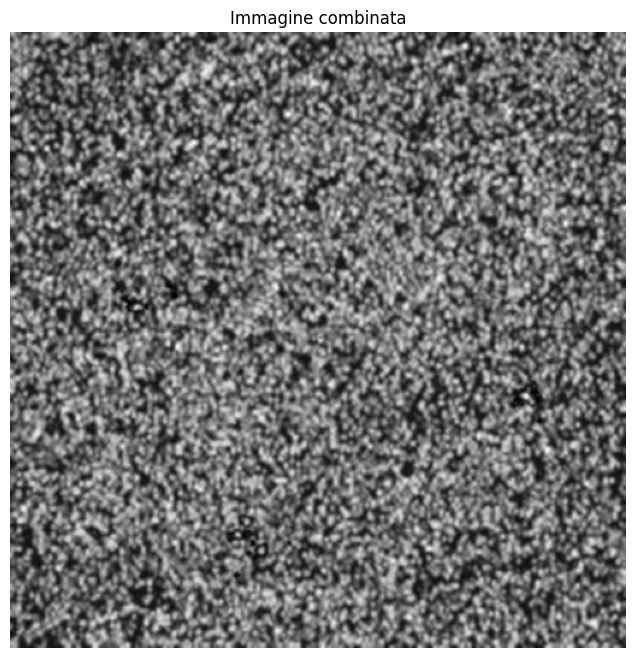

In [111]:
import numpy as np
import matplotlib.pyplot as plt
# Percorso al file .npy
npy_path = "/home/fede/Desktop/jet_patch_excl/Combined_Poisson_1_npy/image_poisson_1991.npy"

# Carica l'array
img = np.load(npy_path)

# Visualizza l'immagine
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title("Immagine combinata")
plt.axis('off')
plt.show()

# DATASET SINTETICO

In [105]:
from itertools import combinations
import pandas as pd

data = [
    ("DLCS_0001", "DLCS_0001_01", "DLCS_0001.nii.gz", 435, 374, 101, 6, 6, 3),
    ("DLCS_0001", "DLCS_0001_02", "DLCS_0001.nii.gz", 157, 227, 170, 9, 9, 5),
    ("DLCS_0002", "DLCS_0002_01", "DLCS_0002.nii.gz", 295, 181, 145, 7, 7, 4),
    ("DLCS_0003", "DLCS_0003_01", "DLCS_0003.nii.gz", 119, 166, 136, 5, 5, 3),
    ("DLCS_0004", "DLCS_0004_01", "DLCS_0004.nii.gz", 95, 249, 170, 10, 10, 5),
    ("DLCS_0005", "DLCS_0005_01", "DLCS_0005.nii.gz", 115, 162, 118, 6, 5, 3),
    ("DLCS_0005", "DLCS_0005_02", "DLCS_0005.nii.gz", 165, 281, 164, 8, 8, 5),
    ("DLCS_0005", "DLCS_0005_03", "DLCS_0005.nii.gz", 95, 178, 154, 7, 7, 4),
    ("DLCS_0005", "DLCS_0005_04", "DLCS_0005.nii.gz", 332, 293, 120, 7, 7, 4),
    ("DLCS_0006", "DLCS_0006_01", "DLCS_0006.nii.gz", 318, 196, 279, 6, 6, 4),
    ("DLCS_0006", "DLCS_0006_02", "DLCS_0006.nii.gz", 330, 182, 112, 6, 5, 3),
    ("DLCS_0007", "DLCS_0007_01", "DLCS_0007.nii.gz", 296, 192, 190, 9, 9, 5),
    ("DLCS_0007", "DLCS_0007_02", "DLCS_0007.nii.gz", 329, 274, 108, 5, 5, 3),
    ("DLCS_0007", "DLCS_0007_03", "DLCS_0007.nii.gz", 318, 160, 100, 19, 19, 11),
    ("DLCS_0008", "DLCS_0008_01", "DLCS_0008.nii.gz", 52, 179, 89, 12, 12, 7),
    ("DLCS_0009", "DLCS_0009_01", "DLCS_0009.nii.gz", 109, 162, 178, 7, 7, 4),
    ("DLCS_0010", "DLCS_0010_01", "DLCS_0010.nii.gz", 328, 206, 202, 12, 12, 6),
    ("DLCS_0010", "DLCS_0010_02", "DLCS_0010.nii.gz", 371, 186, 152, 6, 6, 4),
    ("DLCS_0010", "DLCS_0010_03", "DLCS_0010.nii.gz", 350, 324, 114, 10, 10, 6)
]
 
# Creazione DataFrame
columns = ["patient_id", "nodule_id", "ct_nifti_file", "coordX", "coordY", "coordZ", "w", "h", "d"]
df = pd.DataFrame(data, columns=columns)


def compute_max_intersection_count(group):
    nodules = []
    for _, row in group.iterrows():
        z_min = row['coordZ'] - row['d'] // 2
        z_max = row['coordZ'] + row['d'] // 2
        nodules.append((z_min, z_max))
    
    max_n = 1
    k = len(nodules)
    
    for n in range(2, k + 1):
        for comb in combinations(nodules, n):
            z_mins = [z[0] for z in comb]
            z_maxs = [z[1] for z in comb]
            if max(z_mins) <= min(z_maxs):
                max_n = n
                break  # Trova almeno una combinazione ⇒ aggiorna max_n e passa a n+1
    return max_n

# Applica per ogni paziente
result = df.groupby("patient_id").apply(compute_max_intersection_count).reset_index(name="max_intersecting_nodules")

print(result)


  patient_id  max_intersecting_nodules
0  DLCS_0001                         1
1  DLCS_0002                         1
2  DLCS_0003                         1
3  DLCS_0004                         1
4  DLCS_0005                         2
5  DLCS_0006                         1
6  DLCS_0007                         1
7  DLCS_0008                         1
8  DLCS_0009                         1
9  DLCS_0010                         1


/tmp/ipykernel_13327/1651707963.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby("patient_id").apply(compute_max_intersection_count).reset_index(name="max_intersecting_nodules")


In [6]:
from collections import defaultdict, Counter
import pandas as pd

# === 1. Carica il CSV ===
df = pd.read_csv('/home/fede/Desktop/dlcs_annotations.csv')

# === 2. Verifica colonne ===
required_columns = {"patient-id", "coordZ", "d", "Malignant_lbl"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Il CSV deve contenere le colonne: {required_columns}")

# === 3. Analizza overlap su Z e distribuzione malignità ===
def analyze_z_overlap_with_malignancy(df, max_nodules=10):
    all_overlap_counts = Counter()
    malignancy_counts = defaultdict(Counter)
    z_sections_by_label = {0: set(), 1: set()}
    z_sections_only_label = {0: set(), 1: set()}

    for patient_id, group in df.groupby("patient-id"):
        z_to_nodules = defaultdict(list)

        for _, row in group.iterrows():
            z_min = row["coordZ"] - row["d"] // 2
            z_max = row["coordZ"] + row["d"] // 2
            for z in range(z_min, z_max + 1):
                z_to_nodules[z].append(row)

        for z, nodules in z_to_nodules.items():
            n = len(nodules)
            z_key = (patient_id, z)

            # Conti overlap fino a max_nodules
            if n <= max_nodules:
                all_overlap_counts[n] += 1
                n_benign = sum(1 for row in nodules if row["Malignant_lbl"] == 1)
                n_malign = n - n_benign
                malignancy_counts[n][n_malign] += 1

            # Conti per etichetta
            labels_present = {row["Malignant_lbl"] for row in nodules}
            for lbl in labels_present:
                if lbl in z_sections_by_label:
                    z_sections_by_label[lbl].add(z_key)

            # Solo un tipo di etichetta presente
            if labels_present == {0}:
                z_sections_only_label[0].add(z_key)
            elif labels_present == {1}:
                z_sections_only_label[1].add(z_key)

    return all_overlap_counts, malignancy_counts, z_sections_by_label, z_sections_only_label

# === 4. Esegui l'analisi ===
overlap_counts, malignancy_distribution, z_sections_by_label, z_sections_only_label = analyze_z_overlap_with_malignancy(df)

# === 5. Risultati ===
print("📊 Distribuzione per numero di noduli sovrapposti su Z (fino a 10):")
total_sections = sum(overlap_counts.values())

for n in range(1, 11):
    section_count = overlap_counts.get(n, 0)
    prob = (section_count / total_sections * 100) if total_sections else 0
    print(f"\n🔸 {n} nodulo(i): {section_count} sezioni Z ({prob}:%)")
    
    if n in malignancy_distribution:
        print(f"{'Maligni':>10} | {'Benigni':>10} | {'Conteggio sezioni Z':>25}")
        print("-" * 50)
        for n_maligni, count in sorted(malignancy_distribution[n].items()):
            n_benigni = n - n_maligni
            print(f"{n_maligni:>10} | {n_benigni:>10} | {count:>25}")

# === 6. Sezioni Z per etichetta ===
print("\n🧬 Sezioni Z con almeno un nodulo:")
print(f"- Maligno (label 0): {len(z_sections_by_label[0])}")
print(f"- Benigno (label 1): {len(z_sections_by_label[1])}")

print("\n✅ Sezioni Z con **solo** noduli maligni:")
print(f"{len(z_sections_only_label[0])}")

print("\n✅ Sezioni Z con **solo** noduli benigni:")
print(f"{len(z_sections_only_label[1])}")


📊 Distribuzione per numero di noduli sovrapposti su Z (fino a 10):

🔸 1 nodulo(i): 8648 sezioni Z (97.82805429864253:%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          1 |                      1525
         1 |          0 |                      7123

🔸 2 nodulo(i): 188 sezioni Z (2.1266968325791855:%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          2 |                        54
         2 |          0 |                       134

🔸 3 nodulo(i): 4 sezioni Z (0.04524886877828054:%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          3 |                         1
         3 |          0 |                         3

🔸 4 nodulo(i): 0 sezioni Z (0.0:%)

🔸 5 nodulo(i): 0 sezioni Z (0.0:%)

🔸 6 nodulo(i): 0 sezioni Z (0.0:%)

🔸 7 nodulo(i): 0 sezioni Z (0.0:%)

🔸 8 nodul

In [3]:
from collections import defaultdict, Counter
import pandas as pd

# === 1. Carica il CSV ===
df = pd.read_csv('/home/fede/Desktop/dlcs_annotations.csv')

# === 2. Verifica colonne ===
required_columns = {"patient-id", "coordZ", "d", "Malignant_lbl"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Il CSV deve contenere le colonne: {required_columns}")

# === 3. Analizza overlap su Z e distribuzione malignità ===
def analyze_z_overlap_with_malignancy(df, max_nodules=10):
    all_overlap_counts = Counter()
    malignancy_counts = defaultdict(Counter)
    z_sections_by_label = {0: set(), 1: set()}
    z_sections_only_label = {0: set(), 1: set()}

    for patient_id, group in df.groupby("patient-id"):
        z_to_nodules = defaultdict(list)

        for _, row in group.iterrows():
            z_min = row["coordZ"] - row["d"] // 2
            z_max = row["coordZ"] + row["d"] // 2
            for z in range(z_min, z_max + 1):
                z_to_nodules[z].append(row)

        for z, nodules in z_to_nodules.items():
            n = len(nodules)
            z_key = (patient_id, z)

            # Conti overlap fino a max_nodules
            if n <= max_nodules:
                all_overlap_counts[n] += 1
                n_benign = sum(1 for row in nodules if row["Malignant_lbl"] == 1)
                n_malign = n - n_benign
                malignancy_counts[n][n_malign] += 1

            # Conti per etichetta
            labels_present = {row["Malignant_lbl"] for row in nodules}
            for lbl in labels_present:
                if lbl in z_sections_by_label:
                    z_sections_by_label[lbl].add(z_key)

            # Solo un tipo di etichetta presente
            if labels_present == {0}:
                z_sections_only_label[0].add(z_key)
            elif labels_present == {1}:
                z_sections_only_label[1].add(z_key)

    return all_overlap_counts, malignancy_counts, z_sections_by_label, z_sections_only_label

# === 4. Esegui l'analisi ===
overlap_counts, malignancy_distribution, z_sections_by_label, z_sections_only_label = analyze_z_overlap_with_malignancy(df)

# === 5. Risultati ===
print("📊 Distribuzione per numero di noduli sovrapposti su Z (fino a 10):")
total_sections = sum(overlap_counts.values())

for n in range(1, 11):
    section_count = overlap_counts.get(n, 0)
    prob = (section_count / total_sections * 100) if total_sections else 0
    print(f"\n🔸 {n} nodulo(i): {section_count} sezioni Z ({prob:.2f}%)")
    
    if n in malignancy_distribution:
        print(f"{'Maligni':>10} | {'Benigni':>10} | {'Conteggio sezioni Z':>25}")
        print("-" * 50)
        for n_maligni, count in sorted(malignancy_distribution[n].items()):
            n_benigni = n - n_maligni
            print(f"{n_maligni:>10} | {n_benigni:>10} | {count:>25}")

# === 6. Sezioni Z per etichetta ===
print("\n🧬 Sezioni Z con almeno un nodulo:")
print(f"- Maligno (label 0): {len(z_sections_by_label[0])}")
print(f"- Benigno (label 1): {len(z_sections_by_label[1])}")

print("\n✅ Sezioni Z con **solo** noduli maligni:")
print(f"{len(z_sections_only_label[0])}")

print("\n✅ Sezioni Z con **solo** noduli benigni:")
print(f"{len(z_sections_only_label[1])}")

# === 7. Sezioni Z con noduli misti ===
z_mixed = z_sections_by_label[0] & z_sections_by_label[1]
print("\n🧪 Sezioni Z con noduli maligni E benigni (misti):")
print(f"{len(z_mixed)}")


📊 Distribuzione per numero di noduli sovrapposti su Z (fino a 10):

🔸 1 nodulo(i): 8648 sezioni Z (97.83%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          1 |                      1525
         1 |          0 |                      7123

🔸 2 nodulo(i): 188 sezioni Z (2.13%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          2 |                        54
         2 |          0 |                       134

🔸 3 nodulo(i): 4 sezioni Z (0.05%)
   Maligni |    Benigni |       Conteggio sezioni Z
--------------------------------------------------
         0 |          3 |                         1
         3 |          0 |                         3

🔸 4 nodulo(i): 0 sezioni Z (0.00%)

🔸 5 nodulo(i): 0 sezioni Z (0.00%)

🔸 6 nodulo(i): 0 sezioni Z (0.00%)

🔸 7 nodulo(i): 0 sezioni Z (0.00%)

🔸 8 nodulo(i): 0 sezioni Z (0.00%)

🔸 9 nodulo(i): 0 

In [2]:
import pandas as pd
from collections import defaultdict, Counter

# === 1. Carica e verifica il CSV ===
df = pd.read_csv('/home/fede/Desktop/dlcs_annotations.csv')
required_cols = {"patient-id", "coordZ", "d", "Malignant_lbl"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Il CSV deve contenere le colonne: {required_cols}")

# === 2. Analisi overlap su Z ===
def analyze_z_overlap(df, max_nodules=10):
    overlap_counts = Counter()
    malignancy_counts = defaultdict(Counter)
    z_by_label = {0: set(), 1: set()}
    z_only_label = {0: set(), 1: set()}

    for pid, group in df.groupby("patient-id"):
        z_map = defaultdict(list)

        for _, row in group.iterrows():
            z_range = range(row["coordZ"] - row["d"] // 2, row["coordZ"] + row["d"] // 2 + 1)
            for z in z_range:
                z_map[z].append(row)

        for z, nodules in z_map.items():
            n = len(nodules)
            z_key = (pid, z)
            labels = {row["Malignant_lbl"] for row in nodules}

            if n <= max_nodules:
                overlap_counts[n] += 1
                n_malign = sum(row["Malignant_lbl"] == 0 for row in nodules)
                malignancy_counts[n][n_malign] += 1

            for lbl in labels:
                z_by_label[lbl].add(z_key)
            if labels == {0}:
                z_only_label[0].add(z_key)
            elif labels == {1}:
                z_only_label[1].add(z_key)

    return overlap_counts, malignancy_counts, z_by_label, z_only_label

# === 3. Esegui analisi ===
overlap, malignancy, z_by_label, z_only_label = analyze_z_overlap(df)

# === 4. Stampa risultati ===
print("📊 Distribuzione noduli sovrapposti su Z (fino a 10):")
total = sum(overlap.values())
for n in range(1, 11):
    count = overlap.get(n, 0)
    pct = (count / total * 100) if total else 0
    print(f"\n🔸 {n} nodulo(i): {count} sezioni Z ({pct:.2f}%)")
    if n in malignancy:
        print(f"{'Maligni':>10} | {'Benigni':>10} | {'#Sezioni Z':>20}")
        print("-" * 45)
        for mal, cnt in sorted(malignancy[n].items()):
            print(f"{mal:>10} | {n-mal:>10} | {cnt:>20}")

# === 5. Altre statistiche ===
print("\n🧬 Sezioni Z con almeno un nodulo:")
print(f"- Maligni (label 0): {len(z_by_label[0])}")
print(f"- Benigni (label 1): {len(z_by_label[1])}")

print("\n✅ Solo noduli maligni:", len(z_only_label[0]))
print("✅ Solo noduli benigni:", len(z_only_label[1]))

z_mixed = z_by_label[0] & z_by_label[1]
print("\n🧪 Sezioni Z con noduli misti (maligni e benigni):", len(z_mixed))


📊 Distribuzione noduli sovrapposti su Z (fino a 10):

🔸 1 nodulo(i): 8648 sezioni Z (97.83%)
   Maligni |    Benigni |           #Sezioni Z
---------------------------------------------
         0 |          1 |                 1525
         1 |          0 |                 7123

🔸 2 nodulo(i): 188 sezioni Z (2.13%)
   Maligni |    Benigni |           #Sezioni Z
---------------------------------------------
         0 |          2 |                   54
         2 |          0 |                  134

🔸 3 nodulo(i): 4 sezioni Z (0.05%)
   Maligni |    Benigni |           #Sezioni Z
---------------------------------------------
         0 |          3 |                    1
         3 |          0 |                    3

🔸 4 nodulo(i): 0 sezioni Z (0.00%)

🔸 5 nodulo(i): 0 sezioni Z (0.00%)

🔸 6 nodulo(i): 0 sezioni Z (0.00%)

🔸 7 nodulo(i): 0 sezioni Z (0.00%)

🔸 8 nodulo(i): 0 sezioni Z (0.00%)

🔸 9 nodulo(i): 0 sezioni Z (0.00%)

🔸 10 nodulo(i): 0 sezioni Z (0.00%)

🧬 Sezioni Z con al

In [104]:
# creazione dataset sintetico 

import os
import csv
import random
import numpy as np
import cv2
from numpy.random import poisson

# Percorsi delle immagini
path_HToBB = '/home/fede/Desktop/jet_patch_excl/Data_excl/HToBB_25_jet'
path_QCD = '/home/fede/Desktop/jet_patch_excl/Data_excl/QCD_25_jet'
path_TTBar = '/home/fede/Desktop/jet_patch_excl/Data_excl/TTBar_25_jet'

# Parametri
MATRIX_SIZE = 512
IMAGE_SIZE = 130
output_image_dir = "/home/fede/Desktop/jet_patch_excl/Test_medical_distro/"
os.makedirs(output_image_dir, exist_ok=True)
output_csv_path = os.path.join(output_image_dir, "bounding_boxes_medical.csv")

# Funzioni
def get_image_paths(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') and not f.startswith('.') and '.sys.' not in f][:9900]

def rotate_image(image, size):
    angle = random.randint(0, 360)
    center = (size // 2, size // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (size, size), borderMode=cv2.BORDER_CONSTANT, borderValue=0)

def get_bounding_box(image):
    non_zero = np.argwhere(image > 0)
    if non_zero.size == 0:
        return 0, 0, 0, 0
    ymin, xmin = non_zero.min(axis=0)
    ymax, xmax = non_zero.max(axis=0)
    return xmin, ymin, xmax - xmin, ymax - ymin

def place_image(image, bbox, matrix, mask):
    for _ in range(1000):
        x_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
        y_start = random.randint(0, MATRIX_SIZE - IMAGE_SIZE)
        if np.all(mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE]):
            matrix[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = image
            mask[y_start:y_start + IMAGE_SIZE, x_start:x_start + IMAGE_SIZE] = False
            return x_start + bbox[0], y_start + bbox[1], bbox[2], bbox[3]
    return None

def load_images(paths):
    images, bboxes = [], []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = rotate_image(img, IMAGE_SIZE)
        img[img < 20] = 0
        images.append(img)
        bboxes.append(get_bounding_box(img))
    return images, bboxes

# Caricamento
imgs_HToBB = get_image_paths(path_HToBB)
imgs_QCD = get_image_paths(path_QCD)
imgs_TTBar = get_image_paths(path_TTBar)

images_HToBB, bboxes_HToBB = load_images(imgs_HToBB)
images_QCD, bboxes_QCD = load_images(imgs_QCD)
images_TTBar, bboxes_TTBar = load_images(imgs_TTBar)

# Distribuzione target HToBB e QCD
distribution = [
    ("hbb", 1, 2415),
    ("qcd", 1, 515),
    ("hbb", 2, 46),
    ("qcd", 2, 19),
    ("hbb", 3, 3),
    ("qcd", 3, 2),
]

# Prepara CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Intestazione CSV, con i nomi dei bbox corretti
    header = ["image_name"]
    for i in range(1, 4):  # hbb bbox
        header.append(f"hbb{i}_xmin")
        header.append(f"hbb{i}_ymin")
        header.append(f"hbb{i}_width")
        header.append(f"hbb{i}_height")
    for i in range(1, 4):  # qcd bbox
        header.append(f"qcd{i}_xmin")
        header.append(f"qcd{i}_ymin")
        header.append(f"qcd{i}_width")
        header.append(f"qcd{i}_height")
    header.append("label")
    writer.writerow(header)

    idx = 0
    for cls, n_noduli, count in distribution:
        for _ in range(count):
            if idx >= 3000:
                break

            canvas = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uint8)
            mask = np.ones((MATRIX_SIZE, MATRIX_SIZE), dtype=bool)
            entry = [f"image_{idx:04d}.jpg"]

            label = 1 if cls == 'hbb' else 0

            if cls == 'hbb':
                source_images, source_boxes = images_HToBB, bboxes_HToBB
            else:
                source_images, source_boxes = images_QCD, bboxes_QCD

            # Prealloca 3 bbox vuoti per ciascun tipo
            hbb_boxes = [["", "", "", ""] for _ in range(3)]
            qcd_boxes = [["", "", "", ""] for _ in range(3)]

            for i in range(n_noduli):
                if source_images:
                    img = source_images.pop(0)
                    bbox = source_boxes.pop(0)
                    placed = place_image(img, bbox, canvas, mask)
                    box = [placed[0], placed[1], placed[2], placed[3]] if placed else ["", "", "", ""]
                    if cls == "hbb":
                        hbb_boxes[i] = box
                    else:
                        qcd_boxes[i] = box

            # Inserisci immagini TTBar di disturbo
            num_ttbar = poisson(2)
            for _ in range(num_ttbar):
                if images_TTBar:
                    img = images_TTBar.pop(0)
                    bbox = bboxes_TTBar.pop(0)
                    place_image(img, bbox, canvas, mask)

            entry += sum(hbb_boxes, []) + sum(qcd_boxes, [])
            entry.append(label)

            cv2.imwrite(os.path.join(output_image_dir, entry[0]), canvas)
            writer.writerow(entry)
            idx += 1


In [105]:
# check bbox

import os
import csv
import cv2

# Percorsi
input_dir = "/home/fede/Desktop/jet_patch_excl/Test_medical_distro"
csv_path = os.path.join(input_dir, "bounding_boxes_medical.csv")
output_dir = os.path.join(input_dir, "annotated_images")
os.makedirs(output_dir, exist_ok=True)

# Colori BGR
color_hbb = (0, 255, 0)     # Verde per HBB
color_qcd = (0, 0, 255)     # Rosso per QCD

with open(csv_path, mode='r') as file:
    reader = csv.DictReader(file)
    
    for row in reader:
        image_name = row["image_name"]
        image_path = os.path.join(input_dir, image_name)
        image = cv2.imread(image_path)

        # Disegna HBB se presente (fino a 7 oggetti)
        for i in range(1, 4):
            if row[f"hbb{i}_xmin"]:
                x = int(row[f"hbb{i}_xmin"])
                y = int(row[f"hbb{i}_ymin"])
                w = int(row[f"hbb{i}_width"])
                h = int(row[f"hbb{i}_height"])
                cv2.rectangle(image, (x, y), (x + w, y + h), color_hbb, 2)
                cv2.putText(image, f"HBB{i}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_hbb, 1)

        # Disegna QCD se presente (fino a 7 oggetti)
        for i in range(1, 4):
            if row[f"qcd{i}_xmin"]:
                x = int(row[f"qcd{i}_xmin"])
                y = int(row[f"qcd{i}_ymin"])
                w = int(row[f"qcd{i}_width"])
                h = int(row[f"qcd{i}_height"])
                cv2.rectangle(image, (x, y), (x + w, y + h), color_qcd, 2)
                cv2.putText(image, f"QCD{i}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_qcd, 1)

     

        # Salva l'immagine annotata
        cv2.imwrite(os.path.join(output_dir, image_name), image)

print("Immagini annotate salvate in:", output_dir)


Immagini annotate salvate in: /home/fede/Desktop/jet_patch_excl/Test_medical_distro/annotated_images


In [130]:
# ora combino col noise

# qui combino col fondo

import os
import numpy as np
from PIL import Image
import cv2

# Percorsi delle cartelle
folder_jet = "/home/fede/Desktop/jet_patch_excl/Test_medical_distro"
folder_noise = "/home/fede/Desktop/jet_patch_excl/Noise_background"
output_folder = "/home/fede/Desktop/jet_patch_excl/Combined_Medical_npy"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Parametri
target_size = (512, 512)

# Filtra solo file .jpg
jet_files = sorted([f for f in os.listdir(folder_jet) if f.lower().endswith(".jpg")])
noise_files = sorted([f for f in os.listdir(folder_noise) if f.lower().endswith(".jpg")])

# Verifica che il numero di file sia coerente
assert len(jet_files) == len(noise_files), "Il numero di file nelle due cartelle non corrisponde"

# Elaborazione
for i, (jet_name, noise_name) in enumerate(zip(jet_files, noise_files)):
    path_jet = os.path.join(folder_jet, jet_name)
    path_noise = os.path.join(folder_noise, noise_name)

    # Carica e ridimensiona in scala di grigi
    img_jet = Image.open(path_jet).convert('L').resize(target_size)
    img_noise = Image.open(path_noise).convert('L').resize(target_size)

    # Converti in array
    img_jet = np.array(img_jet)
    img_noise = np.array(img_noise)

    brightness_offset = 70
    img_noise = np.clip(img_noise+brightness_offset, 0, 255).astype(np.uint8)

    # Crea la maschera
    mask = img_jet < 100
    # Combina
    combined = np.where(mask, img_noise, img_jet)

    # Applica blur gaussiano
    combined = cv2.GaussianBlur(combined, (5,5), 0)
    #combined =  np.clip(combined+brightness_offset, 0, 255).astype(np.uint8)

    # Salva come file .npy
    output_path = os.path.join(output_folder, f"image_medical_{i:04d}.npy")
    np.save(output_path, combined)

    #if i % 700 == 0:
    #    print(f"Salvata immagine {i+1}/{len(jet_files)}")

print("Elaborazione completata.")

Elaborazione completata.


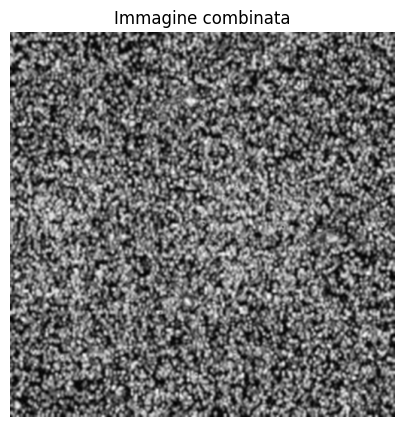

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Percorso al file .npy
npy_path = "/home/fede/Desktop/jet_patch_excl/Combined_Medical_npy/image_medical_0000.npy"

# Carica l'array
img = np.load(npy_path)

# Visualizza l'immagine
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title("Immagine combinata")
plt.axis('off')
plt.show()

In [2]:
import pandas as pd
df = pd.read_csv('/home/fede/Desktop/jet_patch_excl/Combined_Medical_npy/bounding_boxes_medical.csv')

# Funzione per modificare il nome del file
def modifica_nome(file_name):
    # Cambia 'image' in 'image_medical' e '.jpg' in '.npy'
    new_name = file_name.replace('.npy', '.jpg')
    return new_name

# Applica la funzione alla colonna 'image_name'
df['image_name'] = df['image_name'].apply(modifica_nome)

# Salva il DataFrame modificato in un nuovo file CSV (o sostituisci il precedente)
df.to_csv('database_modificato.csv', index=False)

print("Operazione completata con successo!")

Operazione completata con successo!
